In [159]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [160]:
class F:
    @staticmethod
    def B(x, k, i, t):
       if k == 0:
          return 1.0 if t[i] <= x <= t[i+1] else 0.0
       
       if t[i+k] == t[i]:
          c1 = 0.0
       else:
          c1 = (x - t[i])/(t[i+k] - t[i]) * F.B(x, k-1, i, t)
           
       if t[i+k+1] == t[i+1]:
          c2 = 0.0
       else:
          c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * F.B(x, k-1, i+1, t)
       return c1 + c2    
    
    @staticmethod
    def bspline(x, c, range_c, k):
        t = np.concatenate(([range_c[0]] * k, np.linspace(range_c[0], range_c[1], len(c)-k+1), [range_c[1]] * k))
        return sum(c[i] * F.B(x, k, i, t) for i in range(len(c)))
    
    @staticmethod
    def silu(x):
        return x / (1 + np.exp(-x))

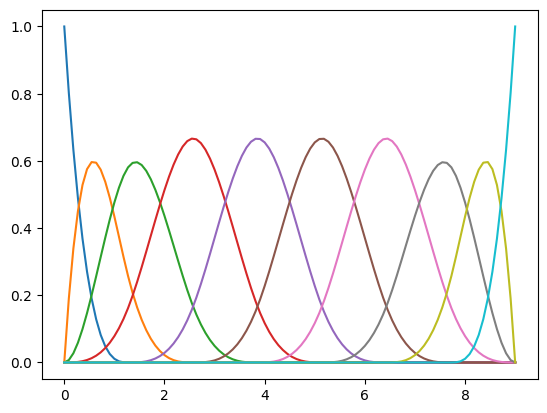

In [161]:
c = [np.random.randn() for _ in range(10)]
k = 3
t = np.concatenate(([0] * k, np.linspace(0, len(c)-1, len(c)-k+1), [len(c)-1] * k))
x = np.linspace(0, len(c)-1 , 100)

for i in range(len(c)):
    y = [F.B(j, k, i, t) for j in x]
    plt.plot(x, y)

In [162]:
class Phi:
    def __init__(self, num_c, range_c, k):
        self.num_c = num_c
        self.range_c = range_c
        self.k = k
        self.c = torch.randn(num_c, requires_grad=True)
        self.w = torch.randn(1, requires_grad=True)
        
    def parameters(self):
        return self.c + self.w
    
    def __call__(self, x):
        return self.w * (F.bspline(x, self.c, self.range_c, self.k) + F.silu(x))
        
    def plot(self):
        x = np.linspace(self.range_c[0], self.range_c[1], 100)
        y = [F.bspline(i, self.c, self.range_c, self.k).detach().numpy() for i in x]
        plt.plot(x, y)
        plt.scatter([i for i in np.linspace(self.range_c[0], self.range_c[1], self.num_c)], self.c.detach().numpy())
        plt.show()

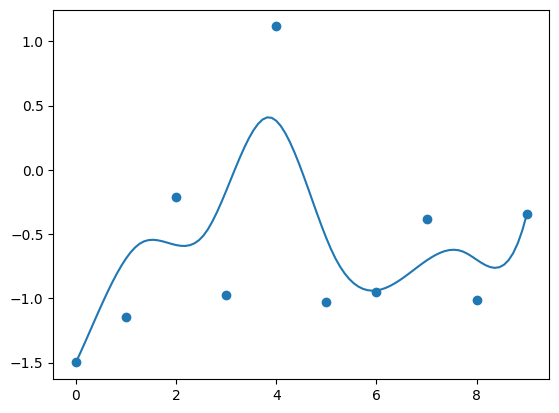

In [183]:
phi = Phi(10, (0, 9), 3)
phi.plot()

In [164]:
class Layer:
    def __init__(self, input_size, output_size, num_control_points, range_c, k):
        self.input_size = input_size
        self.output_size = output_size
        # function[0][3] is the function from input 3 to output 0
        self.functions = [[Phi(num_control_points, range_c, k) for i in range(input_size)] for j in range(output_size)]
        
    def parameters(self):
        param = []
        for i in range(self.output_size):
            for j in range(self.input_size):
                param += self.functions[i][j].parameters()
        return torch.stack(param)
    
    def forward(self, x):
        t = torch.stack([torch.stack([self.functions[i][j](x[j]) for j in range(self.input_size)]) for i in range(self.output_size)])
        return torch.stack([torch.sum(t[i]) for i in range(self.output_size)])
    
    def __call__(self, x):
        return self.forward(x)

In [184]:
class KAN:
    def __init__(self, input_size, layers, num_control_points, range_c, k):
        self.input_size = input_size
        layers = [input_size] + layers
        self.layers = [Layer(layers[i-1], layers[i], num_control_points, range_c, k) for i in range(1, len(layers))]
        
    def parameters(self):
        param = []
        for layer in self.layers:
            param += layer.parameters()
        return param
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __call__(self, x):
        return self.forward(x)

In [166]:
def f1(x, y):
    return x**2 + y**2

def f2(x, y):
    return np.exp(np.sin(x) + y**2)

In [167]:
x = np.linspace(0, 10, 100)
y = np.linspace(0, 100, 100)

X = [[x[i], y[i]] for i in range(len(x))]
X = torch.tensor(X, dtype=torch.float32)

Y = torch.tensor([f1(x, y) for x, y in X], dtype=torch.float32)

In [186]:
kan = KAN(2, [3, 2, 1], 10, (0, 10), 3)
# optimizer = torch.optim.Adam(kan.parameters(), lr=0.01)

print(kan.parameters())

# for i in range(1000):
#     optimizer.zero_grad()
#     y = kan(X)
#     loss = torch.sum((y - Y)**2)
#     loss.backward()
#     optimizer.step()
#     print(loss)


ValueError: can't optimize a non-leaf Tensor